In [1]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import seaborn as sns
import re
import joblib

In [2]:
df = pd.read_csv("Bengaluru_House_Data.csv")

df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


## Cleaning

In [3]:
df['area_type'] = df['area_type'].str.replace("  "," ")
df['price'] = df['price'].astype('float')

df['balcony'] = df['balcony'].fillna(0)
df['bath'] = df['bath'].fillna(0)

df['balcony'] = df['balcony'].apply(lambda x:int(x))
df['bath'] = df['bath'].apply(lambda x:int(x))

In [4]:
df['availability'] = df['availability'].apply(lambda x:"Ready To Move" if x=="Ready To Move" or x=="Immediate Posession" else "Under Construction")

In [5]:
df['size'] = df['size'].astype(str)
df['rooms'] = df['size'].apply(lambda x:int(re.findall(r'\d+', x)[0]) if re.findall(r'\d+',x) else 0)
df['hall'] = df['size'].apply(lambda x: 'H' in x).astype(int)
df['kitchen'] = df['size'].apply(lambda x: 'K' in x).astype(int)

In [6]:
acre_to_sqft = lambda x: float(re.search(r'([\d.]+)', x).group(1)) * 43560 if isinstance(x, str) and re.search(r'Acres?', x, re.IGNORECASE) else x
sqm_to_sqft = lambda x: float(re.search(r'([\d.]+)', x).group(1)) * 10.7639 if isinstance(x, str) and re.search(r'Sq\.?\s?Meter', x, re.IGNORECASE) else x #Sq. Meter
sqyd_to_sqft = lambda x: float(re.search(r'([\d.]+)', x).group(1)) * 9 if isinstance(x, str) and re.search(r'Sq\.?\s?Yards', x, re.IGNORECASE) else x #Sq. Yards
perch_to_sqft = lambda x: float(re.search(r'([\d.]+)', x).group(1)) * 272.25 if isinstance(x, str) and re.search(r'Perch?', x, re.IGNORECASE) else x #Perch or Sq.Rods
cents_to_sqft = lambda x: float(re.search(r'([\d.]+)', x).group(1)) * 435.56 if isinstance(x, str) and re.search(r'Cents?', x, re.IGNORECASE) else x #Cents 
guntha_to_sqft = lambda x: float(re.search(r'([\d.]+)',x).group(1)) * 1089 if isinstance(x, str) and re.search(r'Guntha?', x, re.IGNORECASE) else x #Guntha
ground_to_sqft = lambda x: float(re.search(r'([\d.]+)', x).group(1)) * 2400.35 if isinstance(x, str) and re.search(r'Ground?', x, re.IGNORECASE) else x #Ground

df['total_sqft'] = df['total_sqft'].apply(acre_to_sqft)
df['total_sqft'] = df['total_sqft'].apply(sqm_to_sqft)
df['total_sqft'] = df['total_sqft'].apply(sqyd_to_sqft)
df['total_sqft'] = df['total_sqft'].apply(perch_to_sqft)
df['total_sqft'] = df['total_sqft'].apply(cents_to_sqft)
df['total_sqft'] = df['total_sqft'].apply(guntha_to_sqft)
df['total_sqft'] = df['total_sqft'].apply(ground_to_sqft)

In [7]:
def process_values(x):
    if isinstance(x,(float,int)):
        return float(x)
    if isinstance(x,str):     
        parts=list(map(float, x.split("-")))
        return sum(parts)/2
    return np.nan
    
df['total_sqft'] = df['total_sqft'].apply(lambda x:process_values(x))

In [8]:
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']

In [9]:
df['society'] = df['society'].fillna("No Society")

In [10]:
df = df[~df['location'].isna()]

In [11]:
df = df[df['total_sqft']>=200]
df = df[df['total_sqft']<=50000]
df = df[df['price_per_sqft']<=50000]
df = df[df['price_per_sqft']>=300]

In [12]:
df['price_per_room'] = df['price'] / (df['rooms'] + 1e-6)

In [13]:
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,rooms,hall,kitchen,price_per_sqft,price_per_room
0,Super built-up Area,Under Construction,Electronic City Phase II,2 BHK,Coomee,528.0,2,1,39.07,2,1,1,7399.621212,19.534990
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,1300.0,5,3,120.00,4,0,0,9230.769231,29.999993
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,No Society,720.0,2,3,62.00,3,1,1,8611.111111,20.666660
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,760.5,3,1,95.00,3,1,1,12491.781723,31.666656
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,No Society,600.0,2,1,51.00,2,1,1,8500.000000,25.499987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,1726.5,4,0,231.00,5,0,0,13379.669852,46.199991
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,No Society,1800.0,5,0,400.00,4,1,1,22222.222222,99.999975
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,570.5,2,1,60.00,2,1,1,10517.090272,29.999985
13318,Super built-up Area,Under Construction,Padmanabhanagar,4 BHK,SollyCl,2344.5,4,1,488.00,4,1,1,20814.672638,121.999970


## Encoding

In [14]:
df_cleaned = pd.get_dummies(df,columns=["area_type", "availability"])

In [15]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(['size','price'], axis=1)
y = df_cleaned['price_per_sqft']

X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

In [16]:
from category_encoders import MEstimateEncoder

Me = MEstimateEncoder()

X_train1['location_enc'] = Me.fit_transform(X_train1['location'], y_train)
X_test1['location_enc'] = Me.transform(X_test1['location'])

In [17]:
society_counts = X_train1['society'].value_counts()

threshold = 5
rare_societies = society_counts[society_counts < threshold].index

X_train1['society'] = X_train1['society'].apply(lambda x: "Other" if x in rare_societies else x)

In [18]:
train_freq = X_train1['society'].value_counts(normalize = True)

society_freq = X_train1['society'].value_counts(normalize=True)

X_train1['society_enc'] = X_train1['society'].map(train_freq)
X_test1['society_enc'] = X_test1['society'].map(train_freq).fillna(0)

## Feature Engineering

In [19]:
X_train1['loc_soc_int'] = X_train1['location_enc'] * X_train1['society_enc']
X_test1['loc_soc_int'] = X_test1['location_enc'] * X_test1['society_enc']

In [20]:
X_train1['bed_bath_ratio'] = np.divide(
    X_train1['rooms'],
    X_train1['bath'],
    out=np.zeros_like(X_train1['rooms']),
    where=(X_train1['bath'] > 0) 
)

X_test1['bed_bath_ratio'] = np.divide(
    X_test1['rooms'],
    X_test1['bath'],
    out=np.zeros_like(X_test1['rooms']), 
    where=(X_test1['bath'] > 0)  
)

c:\Users\Chandan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\Chandan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [21]:
X_train1['sqft_per_room'] = np.divide(
    X_train1['total_sqft'],
    X_train1['rooms'],
    out=np.zeros_like(X_train1['total_sqft']),
    where=(X_train1['rooms'] > 0) 
)

X_test1['sqft_per_room'] = np.divide(
    X_test1['total_sqft'],
    X_test1['rooms'],
    out=np.zeros_like(X_test1['total_sqft']), 
    where=(X_test1['rooms'] > 0)  
)

In [22]:
X_train = X_train1.drop(['location','society','price_per_sqft'],axis=1)
X_test = X_test1.drop(['location','society','price_per_sqft'],axis=1)

In [23]:
feature_names = pd.DataFrame(X_train).columns.tolist()

## Scaling

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Models

### Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train,np.log1p(y_train))

y_pred = np.expm1(model.predict(X_test))

In [26]:
from sklearn.metrics import mean_absolute_error, r2_score

print('MAE :',mean_absolute_error(y_test,y_pred))
print('R2_Score :',r2_score(y_test,y_pred))

MAE : 3378.896624303023
R2_Score : 0.4747619649352717


<Axes: ylabel='price_per_sqft'>

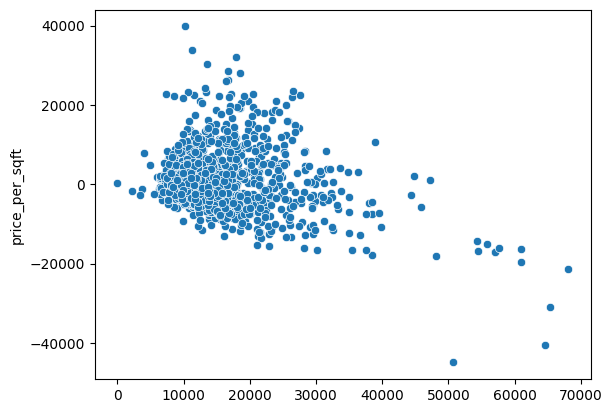

In [27]:
residuals = y_test - y_pred

sns.scatterplot(x=y_pred,y=residuals)

### Gradient Boosting Regressor

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor()

gbm.fit(X_train,y_train)

y_pred_gbm = gbm.predict(X_test)

In [29]:
print("MAE :", mean_absolute_error(y_test,y_pred_gbm))
print("R2_Score :", r2_score(y_test,y_pred_gbm))

MAE : 647.8731810133459
R2_Score : 0.9640910197763949


<Axes: ylabel='price_per_sqft'>

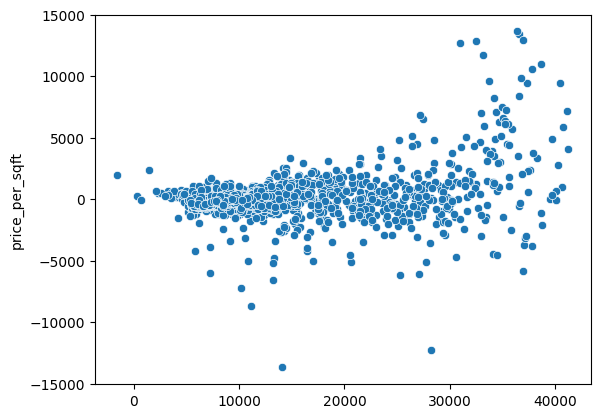

In [30]:
residuals_gbm = y_test - y_pred_gbm

sns.scatterplot(x = y_pred_gbm, y = residuals_gbm)

### Gradient Boost Regressor Quantile

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
gbm_quantile = GradientBoostingRegressor(loss='quantile', alpha=0.5)
gbm_quantile.fit(X_train, y_train)

y_pred_gbm_median=gbm_quantile.predict(X_test)

In [32]:
print("MAE :", mean_absolute_error(y_test,y_pred_gbm_median))
print("R2_Score :", r2_score(y_test,y_pred_gbm_median))

MAE : 722.2476997653097
R2_Score : 0.9234935133905888


<Axes: ylabel='price_per_sqft'>

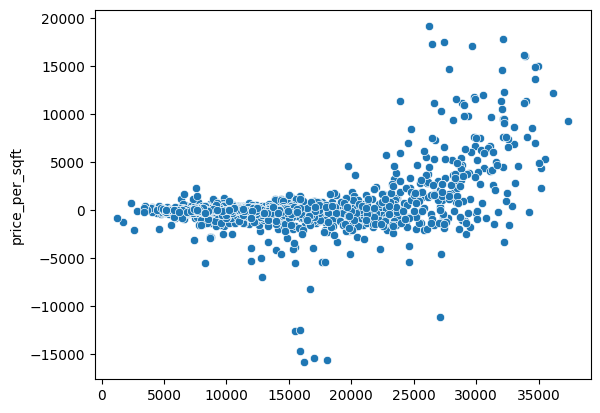

In [33]:
residuals_gbm_median = y_test - y_pred_gbm_median

sns.scatterplot(x = y_pred_gbm_median, y = residuals_gbm_median)

### Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 250,
                         n_jobs = -1,
                         max_depth = 25,
                         min_samples_split = 2,
                         min_samples_leaf = 3,
                         max_features = 0.7,
                         random_state = 42                         
                         )
final_model=rf
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)

In [35]:
print('MAE :',mean_absolute_error(y_test,y_pred_rf))
print('R2_Score :',r2_score(y_test,y_pred_rf))

MAE : 474.9965722441148
R2_Score : 0.953151272480794


<Axes: ylabel='price_per_sqft'>

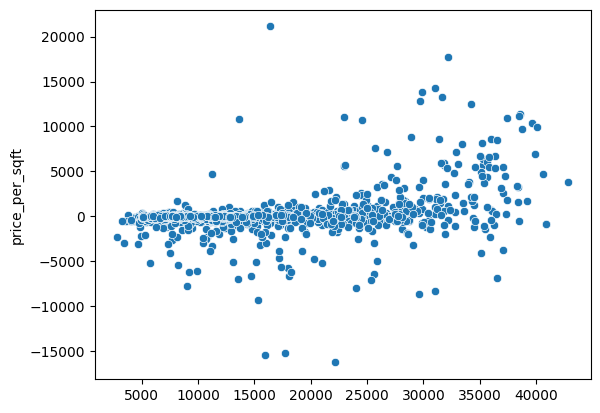

In [36]:
residuals_rf = y_test - y_pred_rf

sns.scatterplot(x = y_pred_rf, y = residuals_rf)

In [37]:
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
X_test=pd.DataFrame(X_test)
y_test=pd.DataFrame(y_test)

In [38]:
X1 = pd.concat([X_train, X_test], axis=0)
y1 =np.array(pd.concat([y_train, y_test], axis=0)).reshape(-1)

final_model.fit(X1, y1)

RandomForestRegressor(max_depth=25, max_features=0.7, min_samples_leaf=3,
                      n_estimators=250, n_jobs=-1, random_state=42)

In [39]:
from sklearn.model_selection import cross_val_predict

# Get predictions for all folds
y_pred_cv = cross_val_predict(
    final_model,
    X1,
    y1,
    cv=5,
    method='predict'
)

print(f"CV R²: {r2_score(y1, y_pred_cv):.3f}")
print(f"CV MAE: {mean_absolute_error(y1, y_pred_cv):.2f} ₹/sqft")

CV R²: 0.970
CV MAE: 376.60 ₹/sqft


<Axes: >

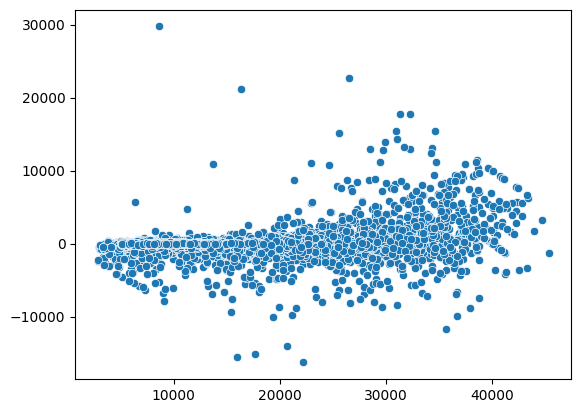

In [40]:
sns.scatterplot(x=y_pred_cv, y=y1 - y_pred_cv)

## Deployment

In [41]:
joblib.dump(feature_names,'feature_names.joblib')                   # For the order of feature names
joblib.dump(final_model, 'model.joblib')                            # Trained RandomForest Model
joblib.dump(scaler, 'scaler.joblib')                                # StandardScaler 
joblib.dump(Me, 'encoder.joblib')                                   # MEstimateEncoder for location
joblib.dump(society_freq, 'society_freq.joblib')                    # Society frequency for encoding society
joblib.dump({                                                       # One hot ecoding of area_types and availability
    'area_types': df['area_type'].unique().tolist(),
    'availability_types': df['availability'].unique().tolist()
}, 'one_hot_columns.joblib')


['one_hot_columns.joblib']

In [42]:
mean_val = float(y_train.mean())
max_val = float(y_train.max())
print(f"Mean: {mean_val:.2f}, Max: {max_val:.2f}")

Mean: 12863.07, Max: 50000.00


C:\Users\Chandan\AppData\Local\Temp\ipykernel_22812\400349188.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_val = float(y_train.mean())
C:\Users\Chandan\AppData\Local\Temp\ipykernel_22812\400349188.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  max_val = float(y_train.max())
